### Задачи исследования

1. изучение имеющихся данных
2. предобработка данных (пропуски, некорректные типы данных, дубликаты)
3. feature engineering (год, месяц, число, цены квадратного метра, отношение площади кухни к общей)
4. построение линейной регрессии для прогнозирования стоимости схожих квартир
5. выводы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('russia_real_estate.csv')
# url: https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021
data.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


- date - date of publication of the announcement (дата публикации объявления);
- time - the time when the ad was published (время публикации объявления);
- geo_lat - Latitude (широта)
- geo_lon - Longitude (долгота)
- region - Region of Russia (регион России). There are 85 subjects in the country in total.
- building_type - Facade type (тип фасада). 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
- object_type - Apartment type (тип квартиры: новостройка/вторичка). 1 - Secondary real estate market; 2 - New building;
- level - Apartment floor (этаж)
- levels - Number of storeys (количество этажей в доме)
- rooms - the number of living rooms (количество жилых комнат). If the value is "-1", then it means "studio apartment"
- area - the total area of the apartment (общая площадь квартиры)
- kitchen_area - Kitchen area (площадь кухни)
- price - Price. in rubles (цена в рублях)

In [4]:
# пропусков нет
data.isnull().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [5]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


**Аномалии**

- Минимальное количество комнат - -2
- Цена меньше 0 руб
- Цена больше 2_000_000_000 руб
- Площадь кухни больше или равна общей площади квартиры
- Этаж квартиры больше общего количества этажей
- Тип квартиры "11", а должен быть "2"

In [6]:
# установим границы для устранения аномалий

MIN_AREA = 20 
MAX_AREA = 200

MIN_KITCHEN = 3
MAX_KITCHEN = 30

MIN_PRICE = 1_000_000
MAX_PRICE = 50_000_000

MIN_ROOMS = 1
MAX_ROOMS = 5

In [7]:
# устраняем аномалии связанные с площадью квартиры
data = data[(data['area'] >= MIN_AREA) & (data['area'] <= MAX_AREA)]

# устраняем аномалии связанные с площадью кухни
data = data[(data['kitchen_area'] >= MIN_KITCHEN) & (data['kitchen_area'] <= MAX_KITCHEN)]  

# устраняем аномалии связанные со стоимостью квартиры
data = data[(data['price'] >= MIN_PRICE) & (data['price'] <= MAX_PRICE)]  

# устраняем аномалии связанные с количеством комнат
data = data[(data['rooms'] >= MIN_ROOMS) & (data['rooms'] <= MAX_ROOMS)]  

# устраняем аномалии связанные с этажами 
data = data[data['level'] <= data['levels']] 

# устраняем аномалии связанные с типом квартиры 
data[data['object_type'] == 11] = 2

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920185 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 525.5+ MB


После устранение выбросов количество записей уменьшилось с 5.5 млн до 4.5 млн :)

# Feature engineering

In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# этаж квартиры по отношению к общему количеству этажей
data['level_to_levels'] = data['level'] / data['levels']

# средняя площадь комнаты в квартире
data['avg_room_size'] = data['area'] / data['rooms']

# доля кухни в обшей площади
data['kitchen_share'] = data['kitchen_area'] / data['area']

In [10]:
# удаляем лишние колонки
data = data.drop(['date', 'time', 'geo_lat', 'geo_lon'] , axis=1)

In [11]:
data.head()

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,day,level_to_levels,avg_room_size,kitchen_share
0,6050000,2661,1,8,10,3,82.6,10.8,1,2018,2,19,0.800000,27.533333,0.130751
1,8650000,81,3,5,24,2,69.1,12.0,1,2018,2,27,0.208333,34.550000,0.173661
2,4000000,2871,1,5,9,3,66.0,10.0,1,2018,2,28,0.555556,22.000000,0.151515
3,2,2,2,2,2,2,2.0,2.0,2,1970,1,1,1.000000,1.000000,1.000000
4,5450000,81,3,13,14,2,60.0,10.0,1,2018,3,1,0.928571,30.000000,0.166667


## Графики

Text(0.5, 1.0, 'Распределение стоимости квартир')

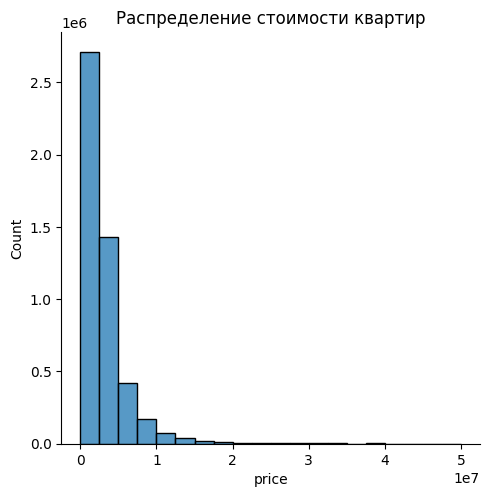

In [12]:
sns.displot(data.price, bins=20)
plt.title("Распределение стоимости квартир")

Text(0.5, 1.0, 'Площадь квартиры')

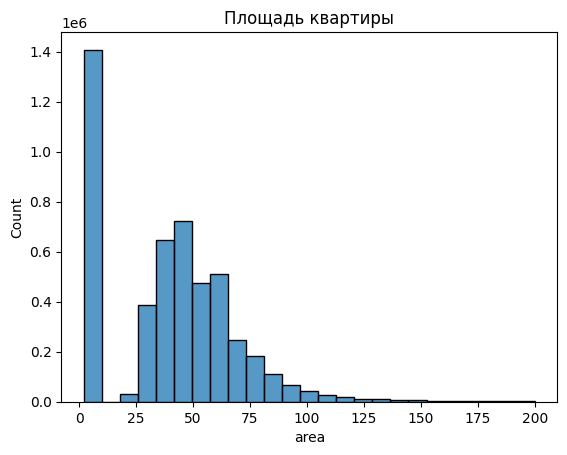

In [13]:
sns.histplot(data['area'], bins=25)
plt.title('Площадь квартиры')

Text(0.5, 1.0, 'Тип фасада')

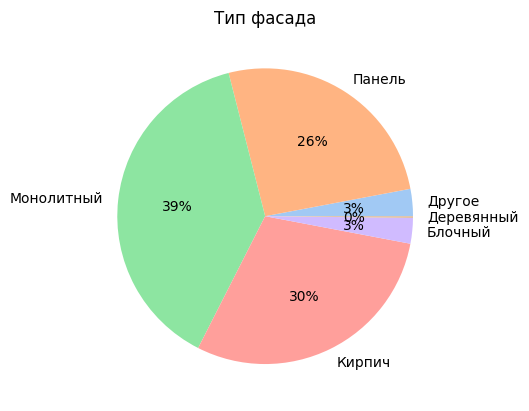

In [14]:
building_types = data['building_type'].value_counts().sort_index(ascending=True)
colors = sns.color_palette('pastel')[0:6]
labels = ['Другое', 'Панель', 'Монолитный', 'Кирпич', 'Блочный', 'Деревянный']
plt.pie(building_types, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Тип фасада')

Text(0.5, 1.0, 'Тип квартиры')

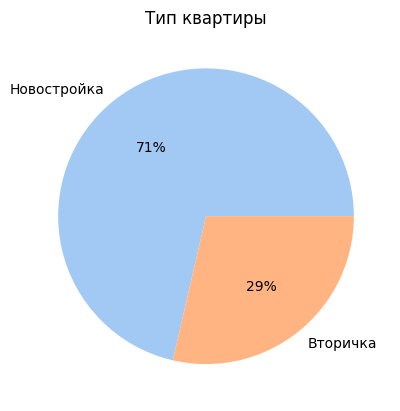

In [15]:
obj_types = data['object_type'].value_counts()
labels = ['Новостройка', 'Вторичка']
colors = sns.color_palette('pastel')[0:2]
plt.pie(obj_types, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Тип квартиры')

Text(0.5, 1.0, 'Количество комнат')

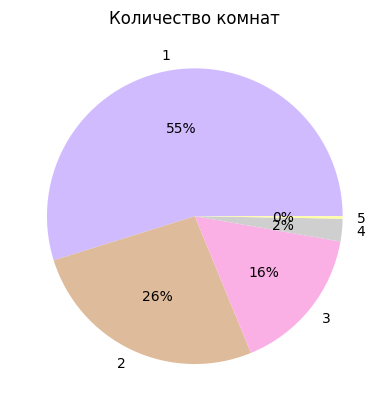

In [16]:
rooms = data['rooms'].value_counts()
colors = sns.color_palette('pastel')[4:9]
labels = ['1', '2', '3', '4', '5']
plt.pie(rooms, labels=labels, colors=colors, autopct="%.0f%%")
plt.title('Количество комнат')


## Корреляция

<AxesSubplot:>

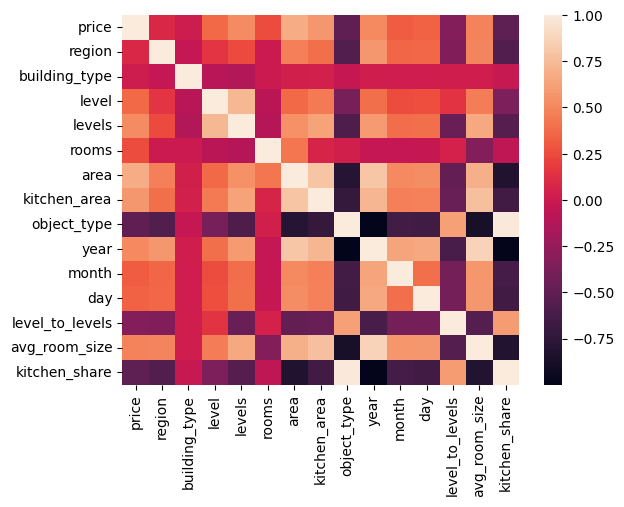

In [17]:
correlation = data.corr()
sns.heatmap(correlation)

In [18]:
correlation[correlation['price'] > 0.1]['price'].sort_values(ascending=False)

price            1.000000
area             0.678714
kitchen_area     0.572719
levels           0.516221
year             0.509087
avg_room_size    0.481792
level            0.369746
day              0.336276
month            0.312757
rooms            0.253041
Name: price, dtype: float64

KeyboardInterrupt: 

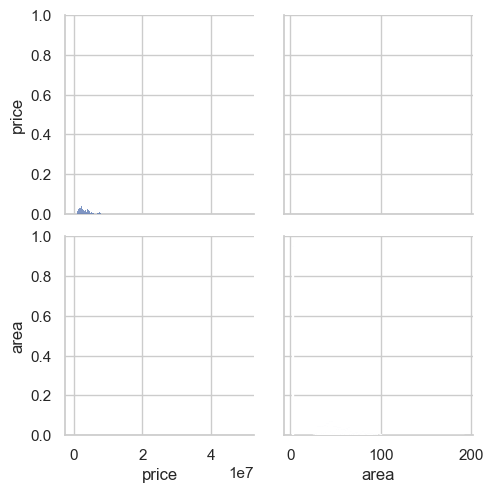

In [19]:
sns.set(style='whitegrid')
sns.pairplot(data[['price', 'area']], kind='reg')

# Построение регрессии

**По всем фичам**

In [20]:
import statsmodels.formula.api as smf 
x = ' + '.join(data.columns.to_list()[1:])
results = smf.ols(f'price ~ {x}', data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                 4.627e+05
Date:                Thu, 29 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:40:11   Log-Likelihood:            -7.9314e+07
No. Observations:             4920185   AIC:                         1.586e+08
Df Residuals:                 4920170   BIC:                         1.586e+08
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.666e+08   3.49e+06   -276.875      0.000   -9.73e+08    -9.6e+08
region           -308.0450      0.433   -711.117      0.000    -308.894    -307.196
building_type   -1.582e+04   1259.406    -12.562      0.000   -1.83e+04   -1.34e+04
level            6721.1239    796.771      8.435      0.000    5159.481    8282.767
levels           1.213e+05    523.193    231.833      0.000     1.2e+05    1.22e+05
rooms           -1.456e+06   5713.657   -254.872      0.000   -1.47e+06   -1.45e+06
area             1.422e+05    258.994    549.163      0.000    1.42e+05    1.43e+05
kitchen_area     -3.34e+04   1063.870    -31.391      0.000   -3.55e+04   -3.13e+04
object_type      2.359e+07   9.73e+04    242.473      0.000    2.34e+07    2.38e+07
year             4.677e+05   1685.584    277.468      0.000    4.64e+05    4.71e+05
month            3.268e+04    415.323     78.682      0.000    3.19e+04    3.35e+04
day                24.2195    140.057      0.173      0.863    -250.287     298.726
level_to_levels -1.451e+05   8998.328    -16.130      0.000   -1.63e+05   -1.28e+05
avg_room_size   -6.749e+04    372.565   -181.139      0.000   -6.82e+04   -6.68e+04
kitchen_share    7.455e+05   5.64e+04     13.214      0.000    6.35e+05    8.56e+05
==============================================================================
Omnibus:                  4863603.910   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        459856033.504
Skew:                           4.678   Prob(JB):                         0.00
Kurtosis:                      49.428   Cond. No.                     1.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**По основным фичам**

In [29]:
results = smf.ols(f'price ~ area + avg_room_size + building_type + levels + kitchen_area', data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 9.792e+05
Date:                Thu, 29 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:42:27   Log-Likelihood:            -7.9682e+07
No. Observations:             4920185   AIC:                         1.594e+08
Df Residuals:                 4920179   BIC:                         1.594e+08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.168e+05   3523.653   -260.187      0.000   -9.24e+05    -9.1e+05
area           7.642e+04     67.641   1129.789      0.000    7.63e+04    7.66e+04
avg_room_size -3.185e+04    132.823   -239.805      0.000   -3.21e+04   -3.16e+04
building_type  1.007e+05   1345.085     74.866      0.000    9.81e+04    1.03e+05
levels         1.598e+05    274.397    582.515      0.000    1.59e+05     1.6e+05
kitchen_area   2.059e+04    463.488     44.432      0.000    1.97e+04    2.15e+04
==============================================================================
Omnibus:                  5086352.855   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        478252587.847
Skew:                           5.069   Prob(JB):                         0.00
Kurtosis:                      50.224   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""